[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zealptl/CSC-44800-Projects/blob/master/final_project/final_project.ipynb)

# CSC 448 - Final Project

## Asbtract

This notebook will explore two datasets. 

The first dataset consists of wildfire data in US between 1992 - 2015. Last year, we had few of the biggest wildfires in US history and it took months to contain them. Using this dataset I was to see if by looking at past data, we can predict how long it will take to contain the fire given the size of the fire. So, I will run a linear regression to do so.

The second dataset consists of employee information of some company with information like their age, salary, awards, certification, etc. Using this data, I want to see if an employee can be classified into one of classes, satisfied or unsatisfied.

In [68]:
import sqlite3 as sql
from sqlite3 import Error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [3]:
%%HTML
<style type='text/css'>
    table.dataframe td, table.dataframe th {
        border-style: solid;
        border-color: #84a9ac;
        border-width: thin;
        width: 150px;
    }
</style>

## Linear Regression

The wildfire dataset is a sqlite database that containes a Fires tables with several columns representing different information about a given fire. For the purpose of this regression I am only selecting the follwing columns

* **FIRE_SIZE:** Estimate of acres within the final perimeter of the fire.
* **STATE:** Two-letter alphabetic code for the state in which the fire originated 
* **DISCOVERY_DATE:** Date on which the fire was dicsovered or confirmed to exist
* **CONT_DATE:** Date on which the fire was declared contained or otherwise controlled
* **FIRE_YEAR:** Calendar yar in which the fire was discovered or confirmed to exist

We can subtract the **DISCOVERAY_DATE** from **CONT_DATE** to get **Elapsed_Days** and now we can use this and **Fire_Size** to run our regression.

### Queries to read data

There are four different queries I wrote to get the data from the sqlite database.

1. Selects all the fires from 1992 - 2015 in a given state
2. Selects all the fires in US in a given year
3. Selects all the fires in given year and state.
4. Selects all the fires from 1992 - 2015

In [51]:
# create a database connection to a SQLite database 
def create_connection(db_file):
    conn = None
    try:
        conn = sql.connect(db_file)
        return conn
    except Error as e:
        print(e)
        
def select_fires_by_state(conn, state):
    query = "SELECT FIRE_SIZE As Fire_Size, \
                                 STATE As State, \
                                 datetime(DISCOVERY_DATE) AS Discovery_Date, \
                                 datetime(CONT_DATE) AS Contained_Date, \
                                 (CONT_DATE - DISCOVERY_DATE) AS Elapsed_Days \
                                 from Fires \
                                 WHERE STATE = '{}' \
                                 ORDER BY Fire_Size;".format(state)
    
    df = pd.read_sql_query(query, conn)                     
    return df

def select_fires_by_year(conn, year):
    query = "SELECT FIRE_SIZE As Fire_Size, \
                                 STATE As State, \
                                 datetime(DISCOVERY_DATE) AS Discovery_Date, \
                                 datetime(CONT_DATE) AS Contained_Date, \
                                 (CONT_DATE - DISCOVERY_DATE) AS Elapsed_Days \
                                 from Fires \
                                 WHERE FIRE_YEAR = {} \
                                 ORDER BY Fire_Size;".format(year)
    
    df = pd.read_sql_query(query, conn)                   
    return df

def select_fires_by_state_year(conn, state, year):
    query = "SELECT FIRE_SIZE As Fire_Size, \
                                 STATE As State, \
                                 datetime(DISCOVERY_DATE) AS Discovery_Date, \
                                 datetime(CONT_DATE) AS Contained_Date, \
                                 (CONT_DATE - DISCOVERY_DATE) AS Elapsed_Days \
                                 from Fires \
                                 WHERE  STATE = '{}' AND FIRE_YEAR = {} \
                                 ORDER BY Fire_Size;".format(state, year)
    
    df = pd.read_sql_query(query, conn)                   
    return df

def select_all_fires(conn):
    query = "SELECT FIRE_SIZE As Fire_Size, \
                                 STATE As State, \
                                 datetime(DISCOVERY_DATE) AS Discovery_Date, \
                                 datetime(CONT_DATE) AS Contained_Date, \
                                 (CONT_DATE - DISCOVERY_DATE) AS Elapsed_Days \
                                 from Fires \
                                 ORDER BY Fire_Size;"
    
    df = pd.read_sql_query(query, conn)                   
    return df

connection = create_connection("us_fires.sqlite")

### Clean data

For the purpose of this regression I will be selecting all the fires between 1992 - 2015. There are some clear outliers in the data. For example, there are fires which less that 1 acre in size but they look more than 3000 days to contain. We can see that this must be a mistake in data entry. Therefore, I am dropping all the fires which were less than 1 acre in size and took more than 100 days to contain. Furthermore, there are also some fires where there is no record of the date of they were contained. So, I am dropping those rows using the *dropna* function of pandas.

,Fire_Size,State,Discovery_Date,Contained_Date,Elapsed_Days
8,0.0001,PA,2002-07-23 00:00:00,2002-07-23 00:00:00,0.0
9,0.0001,PA,2002-07-24 00:00:00,2002-07-24 00:00:00,0.0
10,0.0001,PA,2003-04-13 00:00:00,2003-04-13 00:00:00,0.0
11,0.0001,PA,2003-04-14 00:00:00,2003-04-14 00:00:00,0.0
12,0.0001,NE,2014-03-13 00:00:00,2014-03-13 00:00:00,0.0
...,...,...,...,...,...
1880460,517078.0000,AK,2009-06-21 00:00:00,2009-09-11 00:00:00,82.0
1880461,537627.0000,AK,2004-06-13 00:00:00,2004-09-30 00:00:00,109.0
1880462,538049.0000,AZ,2011-05-29 00:00:00,2011-07-12 00:00:00,44.0
1880463,558198.3000,OR,2012-07-08 00:00:00,2012-07-30 00:00:00,22.0


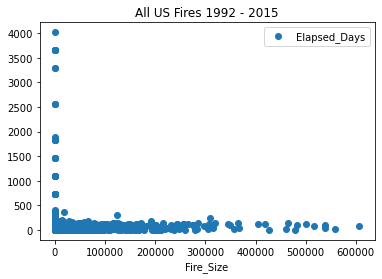

In [50]:
states = [ 'AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FM', 'FL', 'GA', 'GU', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MH', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'MP', 'OH', 'OK', 'OR', 'PW', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VI', 'VA', 'WA', 'WV', 'WI', 'WY' ];
    
df = select_all_fires(connection)
df = df.dropna(how='any', axis=0)
outliers = df[ (df['Elapsed_Days'] > 100) & (df['Fire_Size'] < 1)]
    
display(df)
df.plot(x='Fire_Size', y='Elapsed_Days', style='o', title='All US Fires 1992 - 2015')

### Split Data
Here, we can use *train_test_split* from sklearn to split our data into four arrays.
* *X_train* is an array of Fire_Size that will be used to train the regression model
* *y_train* is an array of Elapsed_Days that will be used to train the regression model
* *X_test* is an array of Fire_Size that will be used to predict the *y_pred* which is the result of *X_test* applied to the trained model

In [130]:
X_train, X_test, y_train, y_test = train_test_split(df[['Fire_Size']], df[['Elapsed_Days']], test_size=0.2, shuffle=True)

### Training Regression Model

Here, we use *LinearRegression* from sklearn to train our regression model. First, we create an object of *linear_model* class and then we can use the *fit* function. The *fit* function takes *X_train* and *y_train* as its arguments so builds a regression model

In [98]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

### Testing Regression Model & Plotting Results

Now that we have trained our model its times to test it. To do so, we can use the *predict* function which takes in *X_test* as an argument and returns an array that consists of estimated time to contain fire calculated using the hypothesis function.

Once we have gotten our *y_pred* we can plot the results using matplotlib. First we plot our test data points (in black). Then we can plot our predictions using the plot function where we pass in *X_test* and the corresponding y values that we predicted using our model (in blue).

Coefficients:  [[0.00041715]]
Mean squared error: 134.78523126722789
Coefficient of determination: 0.013514494797872034


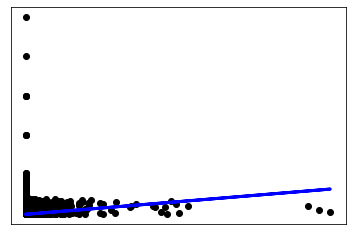

In [131]:
y_pred = regr.predict(X_test)

print('Coefficients: ', regr.coef_)
print('Mean squared error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Coefficient of determination: {}'.format(r2_score(y_test, y_pred)))

plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Regression conclusion

The mean squared error of this model is 134.78. This is way higher than I expected. The reason why I think this because there are a lot of data points where the fire takes less than 0 days to contain and it skews the rest of the data. Perhaps in future instead of running regression on elapsed_days we can find out exactly how many hours it took to contain the fire the increase our accuracy.

## Classification 

The employee dataset is a csv file. For the purpose of this classification I want to see if given the following information I can predicit whether an employee is satisfied or unsatisfied with their jobs.

* **age:** Age of the employee.
* **job_level:** The job level of the employee. 
* **rating:** The previous year rating of the employee.
* **awards:** Numbers of awards recieved by an employee.
* **certifcation:** Is the employee certified? 1 if yes, 0 otherwise.
* **salary:** Net salary of the employee.
* **satisfied:** Is the employee satisfied? 1 if yes, 0 otherwise.

### Read data from CSV

We can use *read_csv* function from pandas to read data from CSV file into a pandas dataframe. Here, I am using an array *col_list* to only reads those columns in the array

In [133]:
col_list = ['age', 'job_level', 'rating', 'awards', 'certifications', 'salary', 'satisfied']

es = pd.read_csv('employee_satisfaction.csv', usecols=col_list)
display(es)

,age,job_level,rating,awards,certifications,salary,satisfied
0,28,5,2,1,0,86750,1
1,50,3,5,2,1,42419,0
2,43,4,1,2,0,65715,0
3,44,2,3,0,0,29805,1
4,33,2,1,5,0,29805,1
...,...,...,...,...,...,...,...
495,49,2,5,6,0,29805,1
496,24,2,4,2,0,29805,0
497,34,1,3,2,0,24076,1
498,26,2,1,1,1,29805,0


### Cleaning & preprocessing the data

Here, I first separate input and outputs. For my input *X* is select all the columns except the **satisfied** column. And the **satisfied** column becomes the output.

Next, we split the data into training and test sets using the same method as linear regression example.

Finally, we need to scale the training set. We need to do so because sometime an optimization algorithm does not converge, it usually happens because the problem is not well-conditioned. Therefore, in this example I am using *StandardScaler* function from sklearn to standardize this dataset.

In [65]:
X = es[es.columns[0:6]]
y = es['satisfied']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

pipe = make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.503030303030303

### Training Classification model

Now that we have prepared our data, we can run a classification algorithm on this dataset. For this example, I have chosen to use the Random Forest Classifier algorithm. 

Random forest classifier works by having number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with most votes becomes our model's prediction. I chose to using random forest classifier to train this model because random forest are less influenced by outliers than other algorithms. Furthermore, they dont make any assumptions about the underlying distribution of the data. 

In [66]:
rfmodel = RandomForestClassifier().fit(X_scaled, y_train)
rfmodel.score(X_test, y_test)

0.6

### Classification conclusion

Here, the score of our classification model is 0.6, meaning we were able to predict the correct class for the employee 60% of the time. This is not as accurate we want our model to be but it may give us a rough estimate. 

## Conclusion

In conclusion, this notebook explored two machine learning examples. A linear regression and a classification problem. 

First, we trained a linear regression model to see if we can predict how long it will take to contain a wildfire given its size. The regression model was not as accurate as we would like it to be. So, for future version I would first clean the data a little bit more. In other words, I plan to see if I can find exact number of hours it took to contain the fire and that way we can build a more accurate model. Additionally, I also plan to train other models like has the time to contain fire decreased over the years, and given see if there is a relation between how quickly the fire was contained given its state of origin and size.

Second, we trained a classification model to see if we can predict whether an employee was satisfied or not given information their age, awards, job level, rating, salary, etc. The accuracy of the model we trained was 60%, again not as accurated as we would want it to be. To increase the accuracy of the model in the next version, I am going to preprocess the data in a better way. There are many methods that sklearn provides to better prepare data for classifcation and that is an ideal step for the next version of this model.